In [514]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [518]:
import os
import glob

#path = './CitiBike Project'
extension = 'csv'
#os.chdir(path)
csv_list = glob.glob('*.{}'.format(extension))
print(csv_list)

['yr_2020.csv', 'yr_2018.csv', 'yr_2019.csv', 'yr_2014.csv', 'yr_2015.csv', 'yr_2017.csv', 'yr_2016.csv', 'yr_2013.csv']


In [519]:
df_list = []

for csv_file in csv_list:
    df_temp = pd.read_csv(csv_file,\
                  dtype={"tripduration":int,\
                  "starttime":object,\
                  "stoptime":object,\
                  "start_station_id":float,\
                  "start_station_name":object,\
                  "start_station_latitude":float,\
                  "start_station_longitude":float,\
                  "end_station_id":float,\
                  "end_station_name":object,\
                  "end_station_latitude":float,\
                  "end_station_longitude":float,\
                  "bikeid":int,\
                  "usertype":object,\
                  "birth_year":object,\
                  "gender":int,\
                  "counter":int,\
                  "year":int,\
                  "age":int})
    
    df_list.append(df_temp)

df_all = pd.concat(df_list)

In [520]:
def clean(dataframe):
    
    # remove trips that are longer than 1 hour 
    dataframe = dataframe.loc[dataframe['tripduration']<= 60*60]
    
    #remove longitude and latitude outside of New York area 
    dataframe = dataframe.loc[(dataframe['start_station_latitude']>40) & (dataframe['start_station_latitude']<41)] 
    dataframe = dataframe.loc[(dataframe['end_station_longitude']>-74.5) & (dataframe['end_station_longitude']<-73.5)]
    
    #drop missing end lat and long
    dataframe = dataframe.dropna(subset=['end_station_latitude', 'end_station_latitude'])
    dataframe = dataframe.dropna(subset=['start_station_id', 'start_station_name',\
                                        'end_station_id','end_station_name'])
    
    #imputes missing birth year
    
    return dataframe

In [521]:
df_all = clean(df_all)

In [522]:
df_all_backup = df_all

# Time Series ML 

In [523]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [524]:
df_all['start_date'] = pd.to_datetime(df_all['starttime']).dt.date
df_all = df_all[df_all['start_date'] <  pd.to_datetime('2020-03-01').date()]
y = df_all[['start_date','counter']].groupby('start_date').sum()

y.head(5)

,counter
start_date,
2013-06-01,410
2013-06-02,732
2013-06-03,355
2013-06-04,739
2013-06-05,729


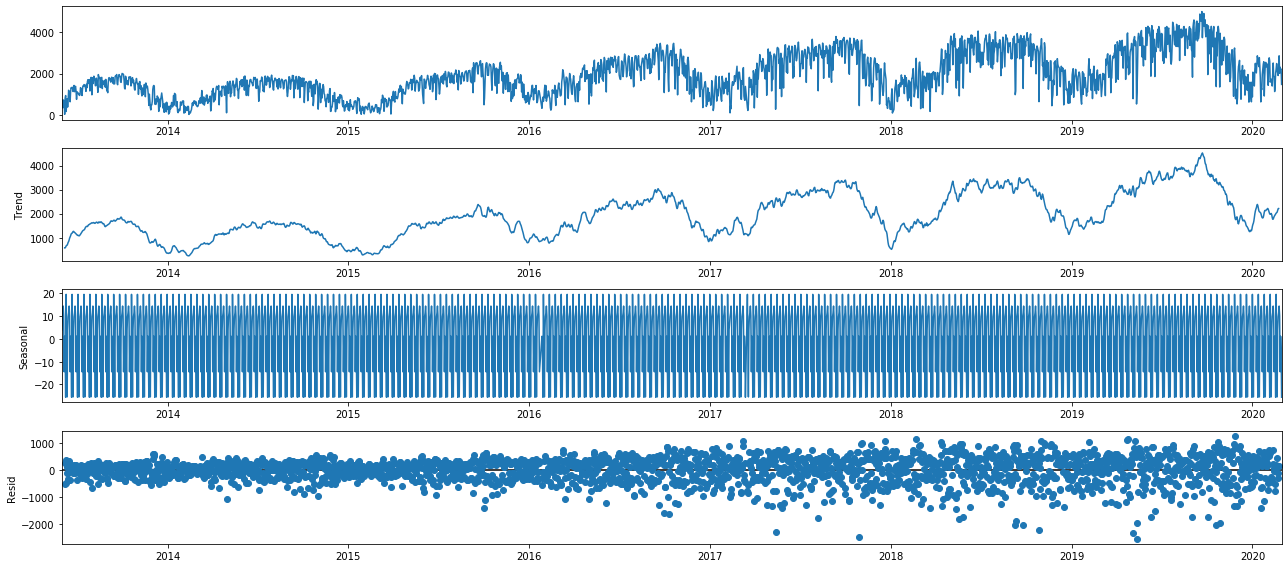

In [525]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, period=12)
fig = decomposition.plot()
plt.show()

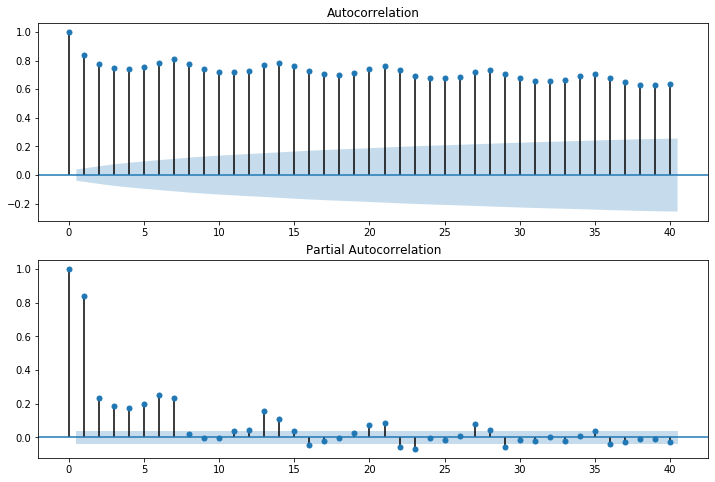

In [165]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y, lags=40, ax=ax2)

In [166]:
#y.index = pd.DatetimeIndex(y.index).to_period('D')


In [167]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(5, 1, 2),
                                seasonal_order=(1, 0, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])
warnings.filterwarnings("ignore")

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1458      0.027     42.045      0.000       1.092       1.199
ar.L2         -0.1259      0.030     -4.205      0.000      -0.185      -0.067
ar.L3         -0.0205      0.031     -0.652      0.514      -0.082       0.041
ar.L4         -0.0571      0.031     -1.867      0.062      -0.117       0.003
ar.L5          0.0491      0.022      2.238      0.025       0.006       0.092
ma.L1         -1.8710      0.020    -95.155      0.000      -1.910      -1.832
ma.L2          0.8708      0.020     44.164      0.000       0.832       0.909
ar.S.L7        0.9689      0.008    115.953      0.000       0.953       0.985
ma.S.L7       -0.8643      0.018    -47.940      0.000      -0.900      -0.829
sigma2      2.238e+05   4776.509     46.845      0.000    2.14e+05    2.33e+05


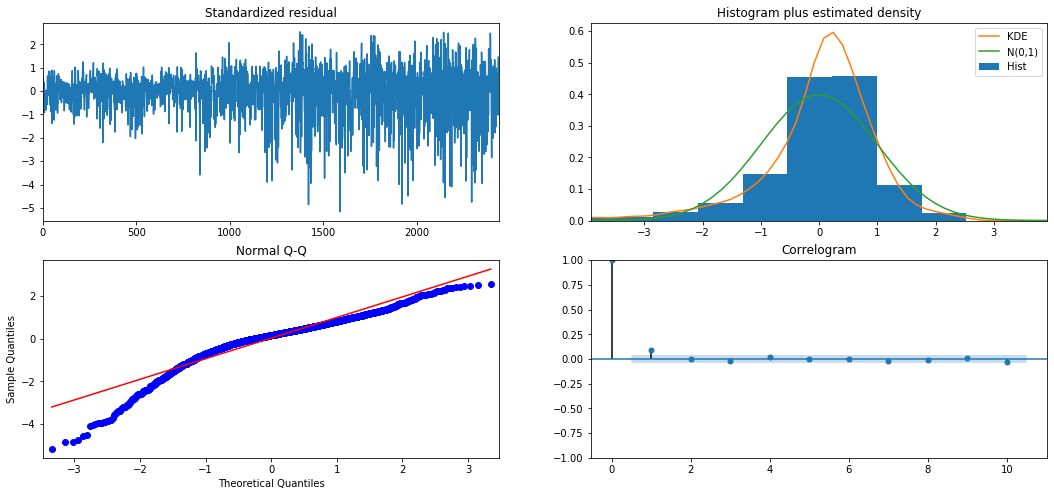

In [168]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

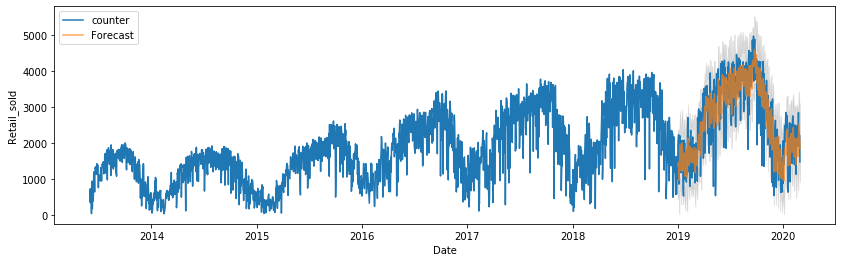

In [169]:
pred = results.get_prediction(start=y.iloc[2032:,].reset_index()['start_date'][0], dynamic=False)
pred_ci = pred.conf_int(.05)
ax = y.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

In [63]:
#y_forecasted.to_frame().reset_index().iloc[:,1]

In [170]:
y_original = df_all[['start_date','counter']].groupby('start_date').sum()

y_forecasted = pred.predicted_mean.to_frame().reset_index().iloc[:,1]
y_truth = y_original.iloc[2032:,].reset_index()['counter']
mse = mean_squared_error(y_forecasted, y_truth)
mae = sum(abs(y_forecasted - y_truth))/len(y_truth)
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))
print('The MAE is {}'.format(round(mae, 2)))

The Mean Squared Error is 372963.93
The Root Mean Squared Error is 610.71
The MAE is 466.13


In [171]:
#R squared
correlation_matrix = np.corrcoef(y_forecasted, y_truth)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print('The R squared is {}'.format(round(r_squared, 2)))

The R squared is 0.67


In [172]:
y_new = y.iloc[2032:,]
y_new = y
y_new.index = pd.to_datetime(y_new.index).to_period('D')

In [173]:
#using indexed y
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(5, 1, 2),
                                seasonal_order=(1, 0, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1458      0.027     42.045      0.000       1.092       1.199
ar.L2         -0.1259      0.030     -4.205      0.000      -0.185      -0.067
ar.L3         -0.0205      0.031     -0.652      0.514      -0.082       0.041
ar.L4         -0.0571      0.031     -1.867      0.062      -0.117       0.003
ar.L5          0.0491      0.022      2.238      0.025       0.006       0.092
ma.L1         -1.8710      0.020    -95.155      0.000      -1.910      -1.832
ma.L2          0.8708      0.020     44.164      0.000       0.832       0.909
ar.S.L7        0.9689      0.008    115.953      0.000       0.953       0.985
ma.S.L7       -0.8643      0.018    -47.940      0.000      -0.900      -0.829
sigma2      2.238e+05   4776.509     46.845      0.000    2.14e+05    2.33e+05


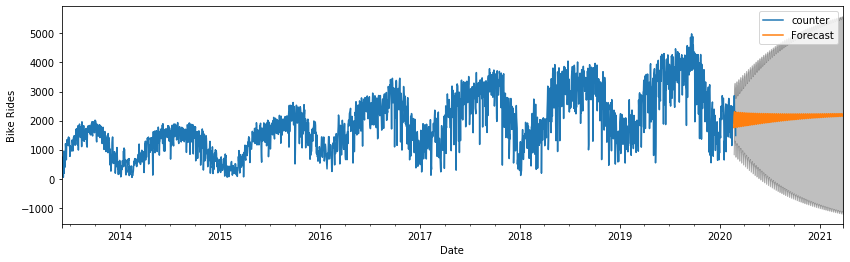

In [174]:
pred_uc = results.get_forecast(steps=400,d=1)
pred_ci = pred_uc.conf_int()
ax = y_new.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Bike Rides')
plt.legend()
plt.show()

# REVENUE 

In [324]:
######REVENUE
#path = './Time_Series/'
#os.chdir(path)

df_revenue = pd.read_csv('revenuets.csv')

In [325]:
df_revenue.head(2)


,Date,Membership and Usage,Sponsorship,Total
0,6-1-2013,"$4,203,421.00","$2,391,667.00","$6,595,088.00"
1,7-1-2013,"$2,398,607.00","$2,497,500.00","$4,896,107.00"


In [326]:
def fixcol(dataframe):
    
    dataframe['membership_and_usage'] = dataframe['Membership and Usage'].\
        apply(lambda x: int(round(float(x.replace(',', '').replace('$','')),0)))
    dataframe['total'] = dataframe['Total'].\
        apply(lambda x: int(round(float(x.replace(',', '').replace('$','')),0)))
    dataframe['sponsorship'] = dataframe['total'] - dataframe['membership_and_usage']
    
    return dataframe

In [327]:
df_rev = fixcol(df_revenue)
df_rev['date'] = pd.to_datetime(df_rev['Date']).dt.date
df_rev = df_rev.drop(['Membership and Usage', 'Sponsorship','Total','Date'], axis=1)


In [328]:
df_rev[['date','total']].to_csv('ts_test.csv')

In [329]:
y1 = df_rev[['date','membership_and_usage']].groupby('date').sum()
y1.head(2)

,membership_and_usage
date,
2013-06-01,4203421
2013-07-01,2398607


In [330]:
y1_backup = y1

In [499]:
y1= y1_backup

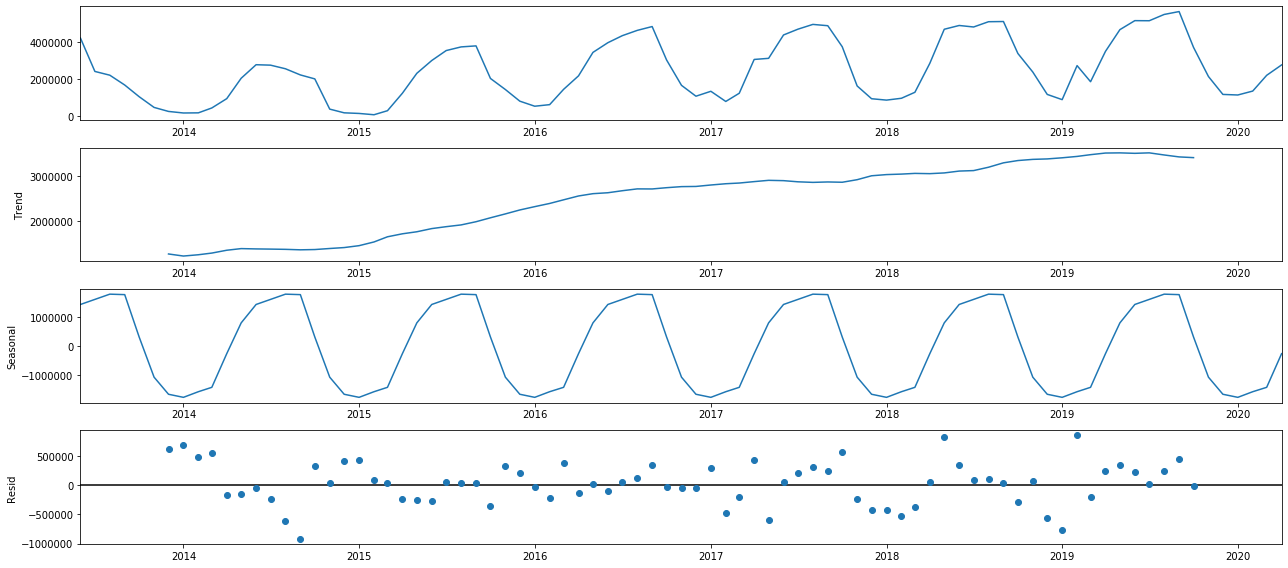

In [500]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y1, period=12)
fig = decomposition.plot()
plt.show()

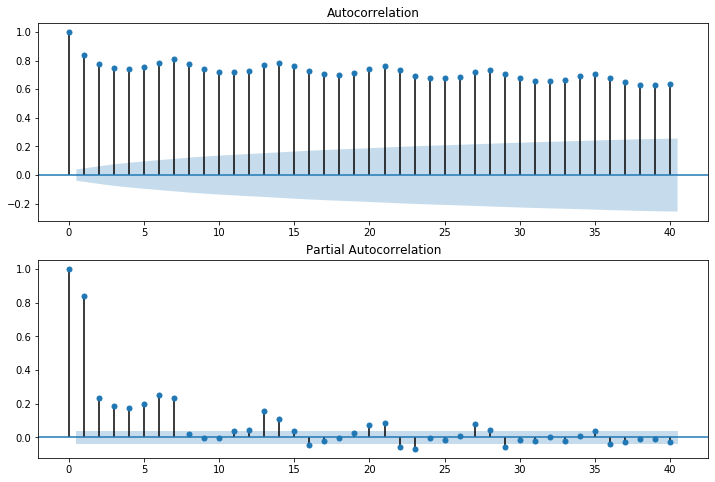

In [501]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y, lags=40, ax=ax2)

In [502]:
mod = sm.tsa.statespace.SARIMAX(y1,
                                order=(5, 1, 2),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])
warnings.filterwarnings("ignore")



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1423      0.347     -0.410      0.682      -0.823       0.538
ar.L2          0.5484      0.563      0.974      0.330      -0.556       1.652
ar.L3          0.5251      0.584      0.899      0.369      -0.619       1.670
ar.L4         -0.0754      0.685     -0.110      0.912      -1.418       1.267
ar.L5         -0.0455      0.503     -0.091      0.928      -1.032       0.941
ma.L1         -0.3766      0.100     -3.749      0.000      -0.573      -0.180
ma.L2         -1.9389      0.177    -10.971      0.000      -2.285      -1.592
ar.S.L12      -0.3320      0.276     -1.203      0.229      -0.873       0.209
sigma2      2.538e+11   7.09e-13   3.58e+23      0.000    2.54e+11    2.54e+11


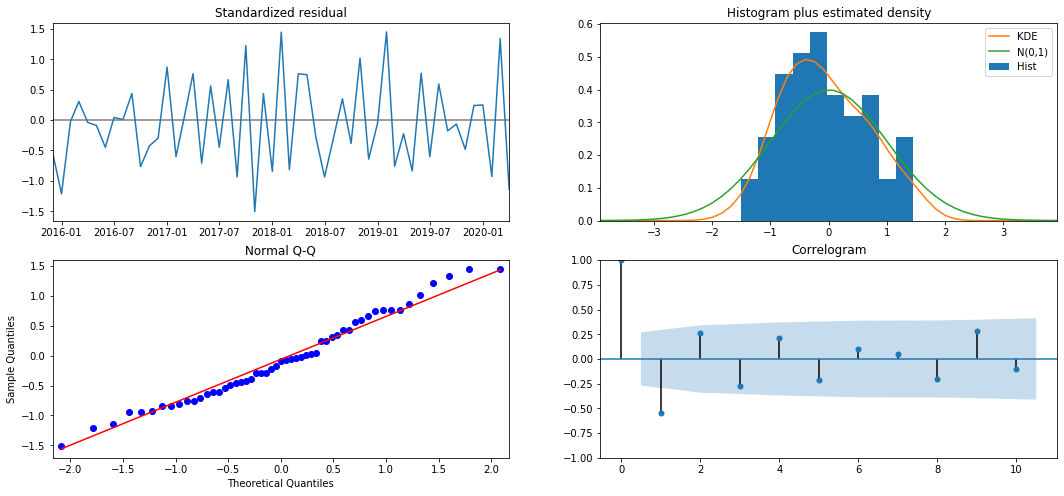

In [503]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

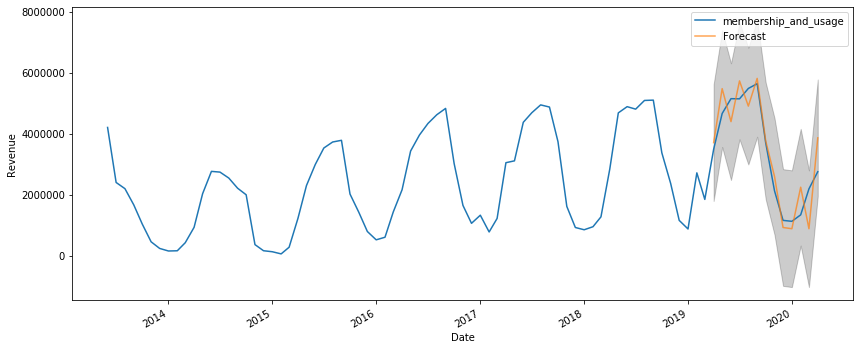

In [504]:
pred = results.get_prediction(start=y1.iloc[70:,].reset_index()['date'][0],\
                              dynamic=False)
pred_ci = pred.conf_int()
ax = y1.plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 6))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.legend()
plt.show()

In [506]:
y1_original = df_rev['total'].iloc[70:,].reset_index()

y_forecasted = pred.predicted_mean.to_frame().reset_index().iloc[:,1]
y_truth = y1_original['total']
mse = mean_squared_error(y_forecasted, y_truth)
mae = sum(abs(y_forecasted - y_truth))/len(y_truth)
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))
print('The MAE is {}'.format(round(mae, 2)))

The Mean Squared Error is 1050884718468.46
The Root Mean Squared Error is 1025126.68
The MAE is 750213.81


In [507]:
#R squared
correlation_matrix = np.corrcoef(y_forecasted, y_truth)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print('The R squared is {}'.format(round(r_squared, 2)))

The R squared is 0.85


In [508]:
#using indexed y
mod = sm.tsa.statespace.SARIMAX(y1,
                                order=(5, 1, 2),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7483      0.339     -5.162      0.000      -2.412      -1.085
ar.L2         -1.2944      0.528     -2.451      0.014      -2.330      -0.259
ar.L3         -0.7443      0.526     -1.415      0.157      -1.775       0.287
ar.L4         -0.4868      0.677     -0.719      0.472      -1.814       0.840
ar.L5         -0.2351      0.500     -0.471      0.638      -1.214       0.744
ma.L1         -0.8256      0.237     -3.479      0.001      -1.291      -0.361
ma.L2         -1.5965      0.311     -5.130      0.000      -2.206      -0.987
ar.S.L12       1.0487      0.089     11.780      0.000       0.874       1.223
ma.S.L12       0.1091      0.188      0.580      0.562      -0.259       0.478
sigma2      3.424e+11   1.95e-12   1.76e+23      0.000    3.42e+11    3.42e+11


In [487]:
y1_new = y1

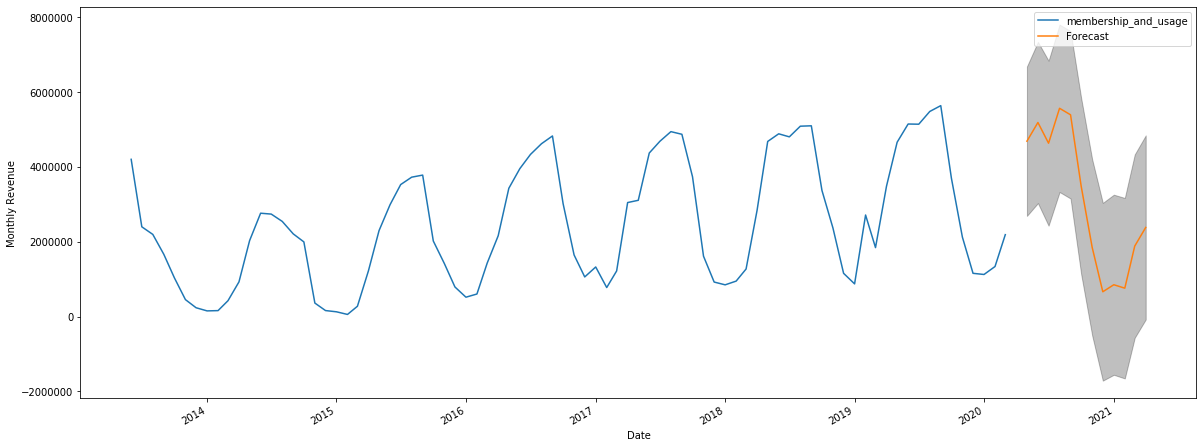

In [509]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = y1_new.plot(label='observed', figsize=(20, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Revenue')
plt.legend()
plt.show()